<a href="https://colab.research.google.com/github/polito-EAD-2026/EAD26-U02.audio-digitale/blob/main/EAD26_U02_audio_digitale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install Librosa
!pip install -q "librosa"
!mkdir -p media
!(cd media; wget "https://github.com/polito-EAD-2026/media/raw/refs/heads/dev/potter.wav")
folder = "./"

--2025-09-19 05:19:12--  https://github.com/polito-EAD-2026/media/raw/refs/heads/dev/potter.wav
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/polito-EAD-2026/media/refs/heads/dev/potter.wav [following]
--2025-09-19 05:19:12--  https://raw.githubusercontent.com/polito-EAD-2026/media/refs/heads/dev/potter.wav
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 777238 (759K) [audio/wav]
Saving to: ‘potter.wav’

potter.wav          100%[===================>] 759.02K  --.-KB/s    in 0.05s   

2025-09-19 05:19:12 (13.7 MB/s) - ‘potter.wav’ saved [777238/777238]



In [ ]:
"""
# Base folder
folder = '/content/gdrive/MyDrive/EAD26/'

# import
from google.colab import drive
# mount
drive.mount('/content/gdrive/', force_remount=True)

# /content/gdrive/MyDrive/EAD26/media/potter.wav

!ln -sf f"{folder}/media/" "/content/media/"
"""

'\n# Base folder\nfolder = \'/content/gdrive/MyDrive/EAD26/\'\n\n# import\nfrom google.colab import drive\n# mount\ndrive.mount(\'/content/gdrive/\', force_remount=True)\n\n# /content/gdrive/MyDrive/EAD26/media/potter.wav\n\n!ln -sf f"{folder}/media/" "/content/media/"\n'

In [ ]:
import librosa
import librosa.display
import soundfile as sf

import numpy as np
import scipy

from matplotlib import pyplot as plt
%matplotlib inline

import IPython
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from pprint import pprint


In [ ]:
def band_pass_filter(audio, sr, low_freq, high_freq):
    nyquist = sr / 2
    low = low_freq / nyquist
    high = high_freq / nyquist
    b, a = scipy.signal.butter(2, [low, high], btype='band')
    return scipy.signal.filtfilt(b, a, audio)

# Keep only frequencies between 300Hz and 3000Hz
# band_passed = band_pass_filter(y, sr, 300, 3000)

In [ ]:
# PySoundFile

# available subtypes for output audio coding
print("Codecs")
pprint(sf.available_subtypes())

# available formats for output audio container
print("Containers")
pprint(sf.available_formats())

Codecs
{'ALAC_16': '16 bit ALAC',
 'ALAC_20': '20 bit ALAC',
 'ALAC_24': '24 bit ALAC',
 'ALAC_32': '32 bit ALAC',
 'ALAW': 'A-Law',
 'DOUBLE': '64 bit float',
 'DPCM_16': '16 bit DPCM',
 'DPCM_8': '8 bit DPCM',
 'DWVW_12': '12 bit DWVW',
 'DWVW_16': '16 bit DWVW',
 'DWVW_24': '24 bit DWVW',
 'FLOAT': '32 bit float',
 'G721_32': '32kbs G721 ADPCM',
 'G723_24': '24kbs G723 ADPCM',
 'G723_40': '40kbs G723 ADPCM',
 'GSM610': 'GSM 6.10',
 'IMA_ADPCM': 'IMA ADPCM',
 'MPEG_LAYER_I': 'MPEG Layer I',
 'MPEG_LAYER_II': 'MPEG Layer II',
 'MPEG_LAYER_III': 'MPEG Layer III',
 'MS_ADPCM': 'Microsoft ADPCM',
 'NMS_ADPCM_16': '16kbs NMS ADPCM',
 'NMS_ADPCM_24': '24kbs NMS ADPCM',
 'NMS_ADPCM_32': '32kbs NMS ADPCM',
 'OPUS': 'Opus',
 'PCM_16': 'Signed 16 bit PCM',
 'PCM_24': 'Signed 24 bit PCM',
 'PCM_32': 'Signed 32 bit PCM',
 'PCM_S8': 'Signed 8 bit PCM',
 'PCM_U8': 'Unsigned 8 bit PCM',
 'ULAW': 'U-Law',
 'VORBIS': 'Vorbis',
 'VOX_ADPCM': 'VOX ADPCM'}
Containers
{'AIFF': 'AIFF (Apple/SGI)',
 'AU': 

In [ ]:
def quantize_uniform_tread(x, N=8):
  qmin, qmax, qlevel = -1, +1, 2**N-1 # defaults
  qstep = (qmax-qmin) / qlevel
  xnorm = (x-qmin) * qlevel / (qmax-qmin)
  xnorm[xnorm > qlevel] = qlevel
  xnorm[xnorm < 0] = 0
  xnorm_quant = np.floor(xnorm)
  xquant = xnorm_quant * (qmax-qmin) / qlevel
  xquant = xquant + qmin + qstep/2
  return xquant

def plot_vs_time(w, t, xlim=None, ylim=[-1, +1], fig=None):
  fig, ax = plt.subplots(figsize=(12,3)) if fig is None else fig
  ax.plot(t,w,'-')
  ax.set_xlabel('Time (s)')
  ax.set_ylabel('Amplitude')
  ax.set_xlim(xlim) if xlim is not None else plt.xlim(t[0],t[-1])
  ax.set_ylim(ylim) if ylim is not None else None
  fig.tight_layout()
  # ax.grid()
  # plt.show()

def SNR(original, quantized):
  noise = quantized - original
  powS = np.sum(original**2)
  powN = np.sum(noise**2)
  return 10*np.log10(powS/powN)

def normalize(x):
  return x / np.max(np.abs(x))

def RMS(x):
  return np.sqrt(np.mean(x**2))

In [ ]:
def plot_graph_quant_function(ax, x, xq, e):
    # title = r'$\lambda = %d, \Delta=%0.2f$' % (quant_level, quant_stepsize)
    ax.plot(x, x, color='k', label='Original')
    ax.plot(x, xq, color='b', label='Quantized')
    ax.plot(x, e, 'r--', label='Error')
    # ax.set_title(title)
    ax.set_xlabel('Amplitude')
    ax.set_ylabel('Quantized Values')
    ax.set_xlim([quant_min, quant_max])
    ax.set_ylim([quant_min, quant_max])
    ax.grid('on')
    ax.legend()

In [ ]:
# Narrowband 300-3400 Hz filtering

low = 300
high = 3400

in_filename = f"{folder}/media/potter.wav"
out_filename = f"{folder}/media/potter.{low}-{high}Hz.wav"

# in_filename = f"{folder}/media/viper.mp3"

y, sr = librosa.load(in_filename, sr=None)
y_ = band_pass_filter(y, sr, low, high)

IPython.display.display( IPython.display.Audio(y,rate=sr) )
IPython.display.display(IPython.display.Audio(y_,rate=sr) )

sf.write(out_filename, y_, sr, subtype='PCM_16')


In [ ]:
# Low bitrate quantization

N = 8
in_filename = f"{folder}/media/potter.wav"
out_filename = f"{folder}/media/potter.{N:02d}bit.wav"

# in_filename = f"{folder}/media/viper.mp3"

y, sr = librosa.load(in_filename, sr=None)

# for N = 2 since the signal level may be too low and result in silence
# y = normalize(y)

y_ = quantize_uniform_tread(y, N)

IPython.display.display( IPython.display.Audio(y,rate=sr) )
IPython.display.display(IPython.display.Audio(y_,rate=sr) )

sf.write(out_filename, y_, sr, subtype='PCM_16')


In [ ]:
# Campionamento: sample rate e istanti di campionamento
Fs = 48000
d = 100 # ms

M = int(np.round((d / 1000) * Fs))
dTs = 1 / Fs * 1000

t1, t2 = 34, 65
i1 = int(np.round(t1/1000 / dTs))
i2 = int(np.round(t2/1000 / dTs))

print(f"M={M}, dTs={dTs:.3f} ms, i1={i1}, i2={i2}")

M=4800, dTs=0.021 ms, i1=2, i2=3


In [ ]:
# Quantizzatore: progetto e calcolo parametri
Xm, N = 1, 3

M = 2**N
Q = 2*Xm / 2**N
d = -Xm + np.arange(M+1) * Q
q = 1/2 * (d[0:-1] + d[1:])

print(f"Q = {Q}")
print(f"d = {d}")
print(f"q = {q}")


Q = 0.25
d = [-1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75  1.  ]
q = [-0.875 -0.625 -0.375 -0.125  0.125  0.375  0.625  0.875]


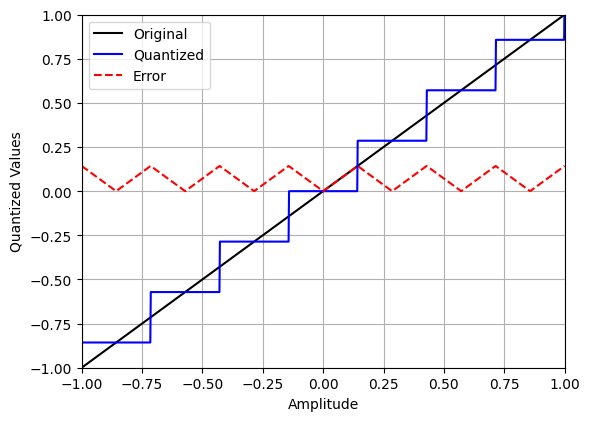

In [ ]:
# Curva caratteristica del quantizzatore
quant_min, quant_max, n = -1, 1, 1000
N = 3
x = np.linspace(quant_min, quant_max, n)
xq = quantize_uniform_tread(x, N)

plt.figure(figsize=(6,8))
ax = plt.subplot(2, 1, 1)
plot_graph_quant_function(ax, x, xq, np.abs(x-xq))
plt.tight_layout()
plt.show()



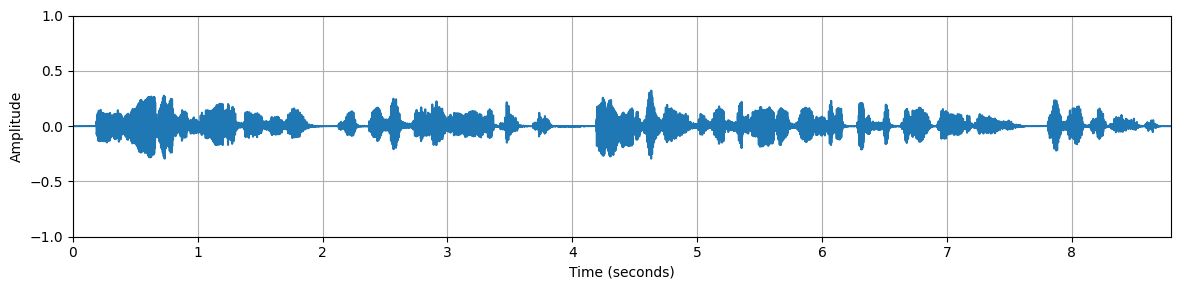

In [ ]:
# Grafico segnale audio nel tempo
from matplotlib import pyplot as plt

in_filename = f"{folder}/media/potter.wav"
w, Fs = librosa.load(in_filename, sr=None)

t = np.arange(y.shape[0]) / Fs

fig, ax = plt.subplots(figsize=(12,3))
ax.plot(t, w, '-')
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Amplitude')
ax.set_xlim([t[0], t[-1]])
ax.set_ylim([-1, 1])
ax.grid()
fig.tight_layout()

Sample float64 precision: 
15 decimal digits


(np.float64(-0.47552825814757677),
 np.float64(-0.6666666666666667),
 np.float64(0.19113840851908998))

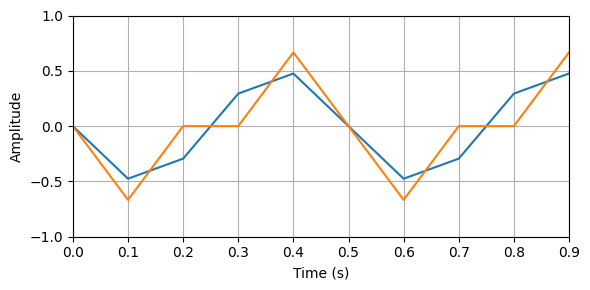

In [ ]:
# Esempio quantizzazione sinusoide (calcolata floating point)

N, Fs, A, f, phi = 10, 10, 0.5, 2, np.pi/2
t = np.arange(N) / Fs
s = 0.5 * np.cos(2 * np.pi * f * t + phi)

print(f'Sample {np.finfo(s[0]).dtype} precision: ')
print(f'{np.finfo(s[0]).precision} decimal digits')

sq = quantize_uniform_tread(s, N=2)
fig, ax = plt.subplots(figsize=(6,3))
plot_vs_time(s,t,fig=(fig,ax))
plot_vs_time(sq,t,fig=(fig,ax))
ax.grid()

i = 1
s[i], sq[i], np.abs(s[i]-sq[i])

In [ ]:

in_filename = f"{folder}/media/potter.wav"
x, Fs = librosa.load(in_filename, sr=None)

powX = np.average(x**2)

@interact(
    N = widgets.IntSlider(min=2, max=8, step=1, value=8, continuous_update=False),
    norm = False
)
def listen_q_error(N, norm):
  global x
  if norm:
    w = normalize(x)
  else:
    w = x

  wq = quantize_uniform_tread(w, N)
  e = w-wq
  print(f'N:{N}, SNR: {SNR(w, wq):.2f} dB\n') # N:8, SNR: 26.87 dB

  # trick avoid normalize playback
  wq[-1] = 1
  e[-1]  = 1

  IPython.display.display(IPython.display.Audio(wq,rate=Fs) )
  IPython.display.display(IPython.display.Audio(e,rate=Fs) )

A range: 10.918207168579102 - 0.3411939740180969


RMS_dB   RMS     SNR    
0   -6.0206  0.5000  10.4611
1   -6.3247  0.4828  10.8612
..      ...     ...      ...
98 -35.8195  0.0162  65.2974
99 -36.1236  0.0156  65.0144

[100 rows x 3 columns]

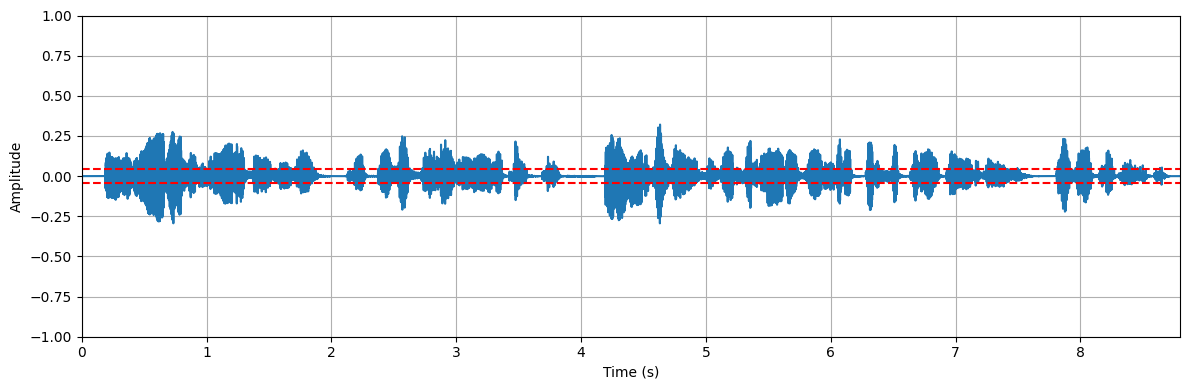

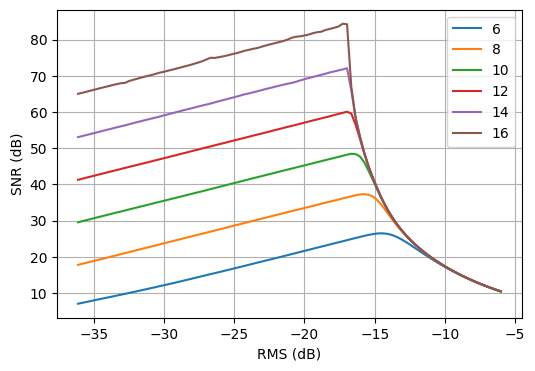

In [ ]:
# Verifica condizioni "ideali" quantizzatore
# SNR vs RMS

import pandas as pd


in_filename = f"{folder}/media/potter.wav"
w, Fs = librosa.load(in_filename, sr=None)
t = np.arange(w.shape[0]) / Fs

sigma_w = RMS(w)
A_from = 1/2**1 / sigma_w    # ratio to scale the signal to get sigma = 2**n
A_to = 1/2**6 / sigma_w
A_v = np.logspace(np.log2(A_from), np.log2(A_to), 100, base=2)
print(f"A range: {A_from} - {A_to}")

# visualizzazione
fig, ax = plt.subplots(figsize=(12,4))
plot_vs_time(w,t, fig=(fig,ax))
ax.grid()
ax.axhline(y=sigma_w, color='r', linestyle='--', label='RMS')
ax.axhline(y=-sigma_w, color='r', linestyle='--', label='RMS')


fig, ax = plt.subplots(figsize=(6,4))

for N in range(6,17,2):
  qsnr_v = np.array([])
  rms_v = np.array([])

  for A in A_v:
    wA = w * A
    wAq = quantize_uniform_tread(wA, N)
    qsnr = SNR(wA, wAq)
    qsnr_v = np.append(qsnr_v, qsnr)
    rms_v = np.append(rms_v, RMS(wA))

  ax.plot(20*np.log10(rms_v), qsnr_v, '-', label=f"{N}")

ax.grid()
ax.legend()
ax.set_ylabel('SNR (dB)')
ax.set_xlabel('RMS (dB)')

df = pd.DataFrame(np.column_stack((20*np.log10(rms_v), rms_v, qsnr_v)), columns=["RMS_dB", "RMS", "SNR"])
df.to_csv('quantizer_snr_vs_rms.csv')


with pd.option_context('display.max_rows', 5,
                       'display.precision', 4,
                       'display.colheader_justify', 'left'):
  display(df)